In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

from common_util import hdi,kbar_jmak,kbar_gl,tbar
import warnings

### $\ln{k_{eff}}$ and $\ln{t_{inc,eff}}$ Bar Charts

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_251512\1762594980.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right', fontsize=12)


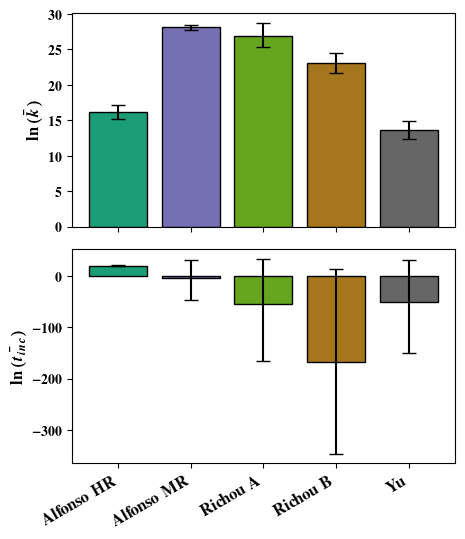

In [9]:
import math

model_name = 'JMAK_{}'
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl
ep = 'n' if 'JMAK' in model_name else 'nu'

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B',
                 'rf_data/yu_data/data.csv': 'Yu et al. (2017)'}

labels = [r'\textbf{' + f'{label}' + '}' for label in ['Alfonso HR', 'Alfonso MR', 'Richou A', 'Richou B', 'Yu']]

T_1 = 800.0 + 273.15
T_2 = 1300.0 + 273.15

# Bar chart for k_bar


data = {'k_bar means': [], 'k_bar lower': [], 'k_bar upper': [], 't_bar means': [], 't_bar lower': [],'t_bar upper': []}   
for data_name in file_to_label.values():
    with open(f'.inference/{model_name.format(data_name)}_samples.pkl','rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f)).iloc[::10]

    for row in samples.index:
        with warnings.catch_warnings(action = 'ignore'): 
            samples.loc[row,'k_bar']=  np.log(kbar(samples.loc[row,'a1'],samples.loc[row,'B1'],samples.loc[row,ep],T_1,T_2))
            samples.loc[row,'t_bar'] = np.log(tbar(samples.loc[row,'a2'],samples.loc[row,'B2'],T_1,T_2))

    lo,hi = hdi(samples['k_bar'].to_numpy().T,0.95).T
    data['k_bar means'].append(samples['k_bar'].mean())
    data['k_bar lower'].append(data['k_bar means'][-1] - lo)
    data['k_bar upper'].append(hi - data['k_bar means'][-1])

    #compute the effective time constant
    lo,hi = hdi(samples['t_bar'].to_numpy().T,0.95).T
    data['t_bar means'].append(samples['t_bar'].mean())
    data['t_bar lower'].append(data['t_bar means'][-1] - lo)    
    data['t_bar upper'].append(hi - data['t_bar means'][-1])



data = pd.DataFrame.from_dict(data)
colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.75, 5.5), sharex=True)
ax1.bar(labels, data['k_bar means'], yerr=data[['k_bar lower','k_bar upper']].to_numpy().T, capsize=5, color=colors,edgecolor = 'k')
ax1.set_ylabel(r'$\ln{(\bar{k})}$',fontsize = 12)

# Bar chart for t_bar
ax2.bar(labels, data['t_bar means'], yerr= data[['t_bar lower','t_bar upper']].to_numpy().T, capsize=5, color= colors,edgecolor = 'k')
ax2.set_ylabel(r'$\ln{(\bar{t_{inc}})}$', fontsize = 12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right', fontsize=12)
fig.tight_layout()
fig.savefig(f'.temp_images/{model_name.format('effective_parameter_estimates')}.svg', bbox_inches='tight')

(10000, 5, 2)


C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_251512\4264050853.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right', fontsize=12)


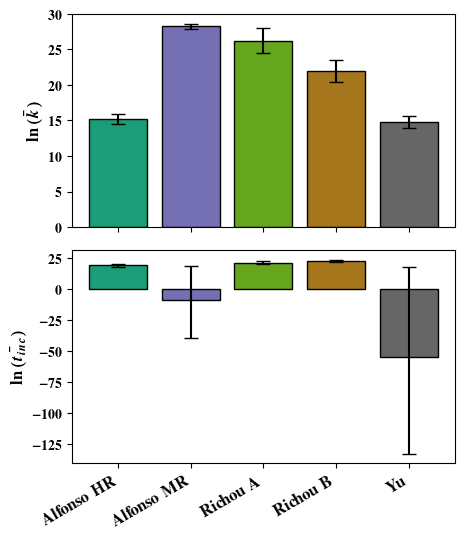

In [ ]:
import math
import warnings

model_name = 'Generalized Logistic_{}'
ep = 'n' if 'JMAK' in model_name else 'nu'

with open(f'.inference/{model_name.format("hierarchical")}_samples.pkl','rb') as f:
    posterior_samples = pickle.load(f)

labels = [r'\textbf{' + f'{label}' + '}' for label in ['Alfonso HR', 'Alfonso MR', 'Richou A', 'Richou B', 'Yu']]


# Bar chart for k_bar 
print(posterior_samples['latent_variables'].shape)
k_bar = pd.DataFrame(posterior_samples['latent_variables'][...,0].mean(axis = 0), columns = ['k_bar'])
k_bar[['lower','upper']] = np.empty((len(k_bar),2))
for i in range(5):
    lo,hi = hdi(posterior_samples['latent_variables'][:,i,0],0.95).T

    with warnings.catch_warnings(action = 'ignore'):
        k_bar['lower'].iloc[i] = k_bar['k_bar'].iloc[i] - lo
        k_bar['upper'].iloc[i] = hi - k_bar['k_bar'].iloc[i]


t_bar = pd.DataFrame(posterior_samples['latent_variables'][...,1].mean(axis = 0), columns = ['t_bar'])
t_bar[['lower','upper']] = np.empty((len(t_bar),2))
for i in range(5):
    lo,hi = hdi(posterior_samples['latent_variables'][:,i,1],0.95).T
    with warnings.catch_warnings(action = 'ignore'):
        t_bar['lower'].iloc[i] = t_bar['t_bar'].iloc[i] - lo
        t_bar['upper'].iloc[i] = hi - t_bar['t_bar'].iloc[i]

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.75, 5.5), sharex=True)
ax1.bar(labels, k_bar['k_bar'], yerr=k_bar[['lower','upper']].to_numpy().T, capsize=5, color=colors,edgecolor = 'k')
ax1.set_ylabel(r'$\ln{(\bar{k})}$',fontsize = 12)

# Bar chart for t_bar
ax2.bar(labels, t_bar['t_bar'], yerr= t_bar[['lower','upper']].to_numpy().T, capsize=5, color= colors,edgecolor = 'k')
ax2.set_ylabel(r'$\ln{(\bar{t_{inc}})}$', fontsize = 12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right', fontsize=12)
fig.tight_layout()
fig.savefig('.temp_images/effective_parameter_estimates_hierarchical.svg', bbox_inches='tight')